# Dynamic Slotting (Zone Assignment) via DQN

This notebook trains a Deep Q-Network (DQN) agent to relocate SKUs across zones to reduce congestion-adjusted picking time while accounting for movement costs.

## Objective & Workflow

1. Load and profile baseline picking performance by zone.
2. Build a slotting simulation environment (congestion, travel distance, move costs).
3. Train a DQN agent (neural network Q-function + replay buffer + target network).
4. Evaluate baseline vs DQN policy on picking time, throughput, congestion, and net value.
5. Visualize learning curves and operational impact.

In [62]:
import math
import random
from collections import deque
from dataclasses import dataclass
from pathlib import Path
from typing import Deque, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Deep Learning (DQN)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Install it in your env, then re-run this cell. "
        "Example: `conda install pytorch pytorch-cuda=12.1 -c pytorch -c nvidia` or `pip install torch`."
    ) from exc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Loading & Feature Engineering

This section mirrors the dataset + engineered features used in the tabular Q-learning notebook, so the DQN results are comparable.

In [63]:
DATA_PATH = Path("logistics_dataset.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,item_id,category,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,storage_location_id,...,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score
0,ITM10000,Pharma,283,21,4,4,49.85,1.56,0.43,L82,...,117.80,1.14,0,0.80,700,3.33,0.33,2024-02-17,184.37,0.556
1,ITM10001,Automotive,301,52,9,6,23.34,2.55,0.69,L15,...,178.80,1.09,3,0.79,736,10.36,0.98,2024-10-01,221.94,0.723
2,ITM10002,Groceries,132,60,11,8,37.69,3.15,0.62,L4,...,54.05,0.95,7,0.75,814,14.32,0.87,2024-04-07,53.85,0.680
3,ITM10003,Automotive,346,46,13,5,33.69,2.79,0.21,L95,...,31.10,1.90,0,0.96,994,2.08,0.29,2024-01-27,92.04,0.488
4,ITM10004,Automotive,49,55,4,6,49.58,5.23,0.31,L36,...,104.97,0.63,5,0.83,299,5.65,0.96,2024-05-17,194.58,0.670


In [64]:
df = df.copy()

zones = sorted(df["zone"].unique())
grid_w = math.ceil(math.sqrt(len(zones)))
grid_h = math.ceil(len(zones) / grid_w)
zone_positions = {zone: (idx // grid_w, idx % grid_w) for idx, zone in enumerate(zones)}
staging_point = np.array([grid_h / 2, grid_w / 2], dtype=float)

zone_totals = df.groupby("zone")["daily_demand"].sum().to_dict()
zone_capacity = {z: max(total * 1.15, total + 25) for z, total in zone_totals.items()}

def travel_distance(zone: str) -> float:
    coord = np.array(zone_positions.get(zone, (0, 0))).astype(float)
    return float(np.linalg.norm(coord - staging_point))

df["zone_coord"] = df["zone"].map(zone_positions)
df["travel_distance"] = df["zone"].map(travel_distance)
df["zone_demand_total"] = df["zone"].map(zone_totals)
df["zone_capacity"] = df["zone"].map(zone_capacity)
df["zone_load_ratio"] = df["zone_demand_total"] / df["zone_capacity"]

df[["item_id", "zone", "daily_demand", "picking_time_seconds", "travel_distance", "zone_load_ratio"]].head()

,item_id,zone,daily_demand,picking_time_seconds,travel_distance,zone_load_ratio
0,ITM10000,B,49.85,106,1.000000,0.869565
1,ITM10001,A,23.34,45,1.414214,0.869565
2,ITM10002,B,37.69,177,1.000000,0.869565
3,ITM10003,A,33.69,39,1.414214,0.869565
4,ITM10004,D,49.58,35,0.000000,0.869565


In [65]:
df["orders_per_hour"] = df["daily_demand"] / 24
baseline_zone_summary = (
    df.groupby("zone")
    .apply(
        lambda g: pd.Series({
            "avg_picking_time": np.average(g["picking_time_seconds"], weights=g["daily_demand"]),
            "avg_travel_distance": np.average(g["travel_distance"], weights=g["daily_demand"]),
            "orders_per_hour": g["orders_per_hour"].sum(),
            "layout_efficiency": np.average(g["layout_efficiency_score"], weights=g["daily_demand"]),
            "labor_utilization": min(1.0, np.average(g["zone_load_ratio"], weights=g["daily_demand"]) * 1.1),
        })
    )
)
baseline_zone_summary

/tmp/ipykernel_4122516/4002978811.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,avg_picking_time,avg_travel_distance,orders_per_hour,layout_efficiency,labor_utilization
zone,,,,,
A,94.084110,1.414214,882.588333,0.606503,0.956522
B,94.691836,1.000000,791.639583,0.607025,0.956522
C,97.056521,1.000000,828.897917,0.598857,0.956522
D,96.697264,0.000000,892.562500,0.597140,0.956522


## Slotting Simulation (Environment)

The environment evaluates each relocation decision using congestion-adjusted picking time, travel effort, and movement overhead. The DQN observes a numeric feature vector and outputs Q-values over zone actions.

In [66]:
@dataclass
class SlottingMetrics:
    baseline_time: float
    new_time: float
    travel: float
    move_cost: float
    reward: float
    demand: float
    layout_score: float
    item_id: str
    old_zone: str
    new_zone: str
    time_gain_seconds: float
    value_gain: float
    net_value: float


SLOT_VALUE_PER_SECOND = 0.22
OVERLOAD_WEIGHT = 55.0
UTILIZATION_SOFT_LIMIT = 0.92
# Penalty applied only when the agent attempts a relocation that is not accepted.
NEGATIVE_MOVE_PENALTY = 5.0
MIN_TIME_GAIN_SECONDS = 45.0
REWARD_SCALE = 100.0
REWARD_CLIP = 50.0


def _get(row: pd.Series, col: str, default: float = 0.0) -> float:
    try:
        val = row[col]
        if pd.isna(val):
            return float(default)
        return float(val)
    except Exception:
        return float(default)


def predict_picking_time(row: pd.Series, target_zone: str, zone_loads: Dict[str, float], capacities: Dict[str, float]) -> float:
    base_time = _get(row, "picking_time_seconds", 60.0)
    load_ratio = zone_loads.get(target_zone, 0.0) / max(capacities.get(target_zone, 1.0), 1.0)
    travel_factor = _get(row, "travel_distance", 0.0) if target_zone == row.get("zone", target_zone) else travel_distance(target_zone)
    layout_bonus = max(0.0, _get(row, "layout_efficiency_score", 0.5) - 0.5)
    congestion_penalty = 1 + 0.45 * min(load_ratio, 2.0)
    travel_penalty = 8 + 6 * travel_factor
    time = base_time * congestion_penalty + travel_penalty - layout_bonus * 6
    return max(time, base_time * 0.5)


class ZoneSlottingEnvDQN:
    def __init__(
        self,
        frame: pd.DataFrame,
        zones: List[str],
        capacities: Dict[str, float],
        feature_stats: Dict[str, float],
        move_cost_base: float = 8.0,
    ):
        self.frame = frame.reset_index(drop=True)
        self.zones = zones
        self.capacities = capacities
        self.action_space = len(zones)
        self.move_cost_base = float(move_cost_base)
        self.feature_stats = feature_stats
        self.zone_to_idx = {z: i for i, z in enumerate(self.zones)}
        self.reset()

    def reset(self) -> List[float]:
        self.items = self.frame.sample(frac=1.0, random_state=None).reset_index(drop=True)
        self.ptr = 0
        self.zone_loads = {z: float(zone_totals.get(z, 0.0)) for z in self.zones}
        self.current_row = self.items.iloc[self.ptr]
        return self._observe(self.current_row)

    def _observe(self, row: pd.Series) -> List[float]:
        # Numeric features (normalized) + one-hot of current zone
        max_demand = max(self.feature_stats.get("max_demand", 1.0), 1.0)
        max_forecast = max(self.feature_stats.get("max_forecast", 1.0), 1.0)
        max_turnover = max(self.feature_stats.get("max_turnover", 1.0), 1.0)
        max_stock = max(self.feature_stats.get("max_stock", 1.0), 1.0)
        max_travel = max(self.feature_stats.get("max_travel", 1.0), 1.0)

        demand = _get(row, "daily_demand", 0.0)
        forecast = _get(row, "forecasted_demand_next_7d", demand)
        turnover = _get(row, "turnover_ratio", 0.0)
        stock = _get(row, "stock_level", 0.0)
        layout = _get(row, "layout_efficiency_score", 0.5)
        travel = _get(row, "travel_distance", 0.0)
        zone = row.get("zone", self.zones[0])
        util = self.zone_loads.get(zone, 0.0) / max(self.capacities.get(zone, 1.0), 1.0)

        # log normalization for heavy-tailed demand/forecast
        demand_n = float(np.log1p(demand) / np.log1p(max_demand))
        forecast_n = float(np.log1p(forecast) / np.log1p(max_forecast))
        turnover_n = float(np.clip(turnover / max_turnover, 0.0, 2.0) / 2.0)
        stock_n = float(np.clip(stock / max_stock, 0.0, 2.0) / 2.0)
        travel_n = float(np.clip(travel / max_travel, 0.0, 1.5) / 1.5)
        layout_n = float(np.clip(layout, 0.0, 1.2) / 1.2)
        util_n = float(np.clip(util, 0.0, 2.0) / 2.0)

        base_features = [forecast_n, turnover_n, util_n, travel_n, stock_n, layout_n, demand_n]
        one_hot = [0.0] * self.action_space
        idx = self.zone_to_idx.get(zone, 0)
        one_hot[idx] = 1.0
        return base_features + one_hot

    @property
    def state_dim(self) -> int:
        return 7 + self.action_space

    def _scale_reward(self, raw_reward: float) -> float:
        scaled = float(raw_reward) / float(REWARD_SCALE)
        return float(np.clip(scaled, -REWARD_CLIP, REWARD_CLIP))

    def step(self, action: int):
        row = self.current_row
        action = int(action)
        target_zone = self.zones[action]
        old_zone = row.get("zone", target_zone)
        demand = _get(row, "daily_demand", 0.0)

        baseline_time = predict_picking_time(row, old_zone, self.zone_loads, self.capacities)

        # IMPORTANT: Treat "stay in current zone" as a valid no-op with zero reward.
        # Penalizing no-ops makes episode returns extremely negative and biases the agent toward unnecessary relocations.
        if target_zone == old_zone:
            metrics = SlottingMetrics(
                baseline_time=baseline_time,
                new_time=baseline_time,
                travel=travel_distance(old_zone),
                move_cost=0.0,
                reward=0.0,
                demand=demand,
                layout_score=_get(row, "layout_efficiency_score", 0.5),
                item_id=str(row.get("item_id", "")),
                old_zone=str(old_zone),
                new_zone=str(old_zone),
                time_gain_seconds=0.0,
                value_gain=0.0,
                net_value=0.0,
            )
            self.ptr += 1
            done = self.ptr >= len(self.items)
            if not done:
                self.current_row = self.items.iloc[self.ptr]
                next_state = self._observe(self.current_row)
            else:
                next_state = [0.0] * self.state_dim
            return next_state, 0.0, bool(done), metrics

        original_loads = dict(self.zone_loads)
        updated_loads = dict(original_loads)
        updated_loads[old_zone] = max(0.0, updated_loads.get(old_zone, 0.0) - demand)
        updated_loads[target_zone] = updated_loads.get(target_zone, 0.0) + demand

        new_time = predict_picking_time(row, target_zone, updated_loads, self.capacities)
        stock_level = _get(row, "stock_level", 0.0)
        move_cost = self.move_cost_base * (1 + stock_level / 200.0)

        time_gain = baseline_time - new_time
        time_gain_seconds = time_gain * demand
        value_gain = time_gain_seconds * SLOT_VALUE_PER_SECOND

        capacity_new = max(self.capacities.get(target_zone, updated_loads[target_zone]), 1.0)
        utilization_new = updated_loads[target_zone] / capacity_new
        overload_penalty = OVERLOAD_WEIGHT * max(utilization_new - 1.0, 0.0) * demand
        soft_penalty = 12.0 * max(utilization_new - UTILIZATION_SOFT_LIMIT, 0.0) * demand

        raw_net_value = value_gain - move_cost - overload_penalty - soft_penalty
        move_accepted = (raw_net_value > 0) and (time_gain_seconds > MIN_TIME_GAIN_SECONDS)

        if move_accepted:
            self.zone_loads = updated_loads
            net_value = raw_net_value
            reward_raw = net_value
        else:
            self.zone_loads = original_loads
            target_zone = old_zone
            new_time = baseline_time
            # attempt was rejected: keep net impact 0 in metrics, but provide learning signal in reward
            net_value = 0.0
            time_gain_seconds = 0.0
            value_gain = 0.0
            reward_raw = raw_net_value - NEGATIVE_MOVE_PENALTY

        reward = self._scale_reward(reward_raw)
        metrics = SlottingMetrics(
            baseline_time=baseline_time,
            new_time=new_time,
            travel=travel_distance(target_zone),
            move_cost=move_cost if move_accepted else 0.0,
            reward=reward,
            demand=demand,
            layout_score=_get(row, "layout_efficiency_score", 0.5),
            item_id=str(row.get("item_id", "")),
            old_zone=str(old_zone),
            new_zone=str(target_zone),
            time_gain_seconds=time_gain_seconds,
            value_gain=value_gain,
            net_value=net_value,
        )

        self.ptr += 1
        done = self.ptr >= len(self.items)
        if not done:
            self.current_row = self.items.iloc[self.ptr]
            next_state = self._observe(self.current_row)
        else:
            next_state = [0.0] * self.state_dim

        return next_state, float(reward), bool(done), metrics

## DQN Agent

This is a standard DQN setup: online Q-network + target network + replay buffer, trained with TD targets and an epsilon-greedy behavior policy.

In [76]:
class EpisodeReplayBuffer:
    def __init__(self, capacity_episodes: int = 500):
        self.capacity_episodes = int(capacity_episodes)
        # Store episodes as CPU tensors so we only pay the Python->Tensor conversion once per episode.
        # Each episode dict contains: states (T,D), actions (T,), rewards (T,), next_states (T,D), dones (T,)
        self.episodes: Deque[Dict[str, torch.Tensor]] = deque(maxlen=self.capacity_episodes)
        self._current: List[Tuple[List[float], int, float, List[float], bool]] = []

    def push(self, state: List[float], action: int, reward: float, next_state: List[float], done: bool):
        self._current.append((list(state), int(action), float(reward), list(next_state), bool(done)))
        if bool(done):
            self.end_episode()

    def end_episode(self):
        if not self._current:
            return
        states = torch.tensor([t[0] for t in self._current], dtype=torch.float32)
        actions = torch.tensor([t[1] for t in self._current], dtype=torch.int64)
        rewards = torch.tensor([t[2] for t in self._current], dtype=torch.float32)
        next_states = torch.tensor([t[3] for t in self._current], dtype=torch.float32)
        dones = torch.tensor([float(t[4]) for t in self._current], dtype=torch.float32)

        # If training on CUDA, pin CPU memory to speed up host->device transfer.
        if device.type == "cuda":
            states = states.pin_memory()
            actions = actions.pin_memory()
            rewards = rewards.pin_memory()
            next_states = next_states.pin_memory()
            dones = dones.pin_memory()

        self.episodes.append({
            "states": states,
            "actions": actions,
            "rewards": rewards,
            "next_states": next_states,
            "dones": dones,
        })
        self._current = []

    def __len__(self) -> int:
        return int(sum(int(ep["actions"].shape[0]) for ep in self.episodes) + len(self._current))

    def sample_sequences(self, batch_size: int, seq_len: int):
        # Sample contiguous sequences from stored episodes (DRQN style)
        seq_len = int(seq_len)
        batch_size = int(batch_size)
        if seq_len <= 0:
            raise ValueError("seq_len must be > 0")
        eligible = [ep for ep in self.episodes if int(ep["actions"].shape[0]) >= seq_len]
        if not eligible:
            raise ValueError("Not enough data to sample sequences yet")

        states_b, actions_b, rewards_b, next_states_b, dones_b = [], [], [], [], []
        for _ in range(batch_size):
            ep = random.choice(eligible)
            t = int(ep["actions"].shape[0])
            start = random.randint(0, t - seq_len)
            end = start + seq_len
            states_b.append(ep["states"][start:end])
            actions_b.append(ep["actions"][start:end])
            rewards_b.append(ep["rewards"][start:end])
            next_states_b.append(ep["next_states"][start:end])
            dones_b.append(ep["dones"][start:end])

        # Stack on CPU then transfer once to target device
        states_t = torch.stack(states_b, dim=0)
        actions_t = torch.stack(actions_b, dim=0)
        rewards_t = torch.stack(rewards_b, dim=0)
        next_states_t = torch.stack(next_states_b, dim=0)
        dones_t = torch.stack(dones_b, dim=0)

        if device.type == "cuda":
            return (
                states_t.to(device, non_blocking=True),
                actions_t.to(device, non_blocking=True),
                rewards_t.to(device, non_blocking=True),
                next_states_t.to(device, non_blocking=True),
                dones_t.to(device, non_blocking=True),
            )
        return (
            states_t.to(device),
            actions_t.to(device),
            rewards_t.to(device),
            next_states_t.to(device),
            dones_t.to(device),
        )


class RecurrentQNetwork(nn.Module):
    # NOTE: This is a BiLSTM Q-network. We keep the name for minimal notebook churn.
    # BiLSTM only sees context within the provided window (no future beyond current time).
    def __init__(self, state_dim: int, action_dim: int, hidden: int = 128, lstm_hidden: int = 128, num_layers: int = 1):
        super().__init__()
        self.state_dim = int(state_dim)
        self.action_dim = int(action_dim)
        self.hidden = int(hidden)
        self.lstm_hidden = int(lstm_hidden)
        self.num_layers = int(num_layers)
        self.num_directions = 2  # bidirectional
        self.context_len = 8  # used by policy/training; can be overridden in training cell
        self.encoder = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(
            input_size=self.hidden,
            hidden_size=self.lstm_hidden,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.head = nn.Linear(self.lstm_hidden * self.num_directions, self.action_dim)

    def forward(self, x: torch.Tensor, hidden=None):
        # x: (B, T, state_dim)
        b, t, d = x.shape
        x = x.reshape(b * t, d)
        z = self.encoder(x).reshape(b, t, self.hidden)
        out, hidden_out = self.lstm(z, hidden)
        q = self.head(out)  # (B, T, action_dim)
        return q, hidden_out


class DRQNAgent:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        lr: float = 3e-4,
        gamma: float = 0.95,
        target_update_interval: int = 500,
        grad_clip: float = 5.0,
    ):
        self.state_dim = int(state_dim)
        self.action_dim = int(action_dim)
        self.gamma = float(gamma)
        self.target_update_interval = int(target_update_interval)
        self.grad_clip = float(grad_clip)

        self.online = RecurrentQNetwork(state_dim, action_dim).to(device)
        self.target = RecurrentQNetwork(state_dim, action_dim).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.target.eval()

        self.optim = optim.Adam(self.online.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()
        self.train_steps = 0
        self.loss_history: List[float] = []

    @torch.no_grad()
    def act(self, state_window: List[List[float]], epsilon: float):
        # state_window: list of recent states, length T (<= context_len), each state length D
        x = torch.tensor([state_window], dtype=torch.float32, device=device)  # (1, T, D)
        q_seq, _ = self.online(x, hidden=None)
        q = q_seq[0, -1]  # Q-values for last timestep
        if random.random() < float(epsilon):
            action = random.randrange(self.action_dim)
        else:
            action = int(torch.argmax(q).item())
        return action

    def update(self, buffer: EpisodeReplayBuffer, batch_size: int, seq_len: int):
        # DRQN update from short sequences.
        if len(buffer.episodes) == 0:
            return None
        try:
            states, actions, rewards, next_states, dones = buffer.sample_sequences(batch_size=batch_size, seq_len=seq_len)
        except ValueError:
            return None

        # states: (B,T,D), actions/rewards/dones: (B,T)
        q_seq, _ = self.online(states, hidden=None)
        q_sa = q_seq.gather(2, actions.unsqueeze(-1)).squeeze(-1)  # (B,T)

        with torch.no_grad():
            q_next_seq, _ = self.target(next_states, hidden=None)
            q_next = q_next_seq.max(dim=2).values  # (B,T)
            td_target = rewards + (1.0 - dones) * self.gamma * q_next

        loss = self.loss_fn(q_sa, td_target)
        self.optim.zero_grad(set_to_none=True)
        loss.backward()
        if self.grad_clip > 0:
            nn.utils.clip_grad_norm_(self.online.parameters(), self.grad_clip)
        self.optim.step()

        self.train_steps += 1
        if self.train_steps % self.target_update_interval == 0:
            self.target.load_state_dict(self.online.state_dict())

        loss_val = float(loss.detach().item())
        self.loss_history.append(loss_val)
        return loss_val

## RL Training (DQN)

We train on a congestion-heavy subset (high zone load ratio) to focus learning where slotting decisions matter most. Training logs include reward, net value, move cost, time saved, epsilon, and loss.

In [77]:
import time

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Focus training on higher-congestion zones
high_pressure = df[df["zone_load_ratio"] >= 0.75]
if len(high_pressure) < 400:
    slotting_subset = (
        df.sort_values(["zone_load_ratio", "daily_demand"], ascending=[False, False])
        .head(600)
        .reset_index(drop=True)
    )
else:
    slotting_subset = high_pressure.sort_values("daily_demand", ascending=False).head(700).reset_index(drop=True)

feature_stats = {
    "max_demand": float(max(1.0, df["daily_demand"].max() if "daily_demand" in df.columns else 1.0)),
    "max_forecast": float(max(1.0, df.get("forecasted_demand_next_7d", df["daily_demand"]).max() if "daily_demand" in df.columns else 1.0)),
    "max_turnover": float(max(1.0, df.get("turnover_ratio", pd.Series([1.0])).max())),
    "max_stock": float(max(1.0, df.get("stock_level", pd.Series([1.0])).max())),
    "max_travel": float(max(1.0, df.get("travel_distance", pd.Series([1.0])).max())),
}

env = ZoneSlottingEnvDQN(slotting_subset, zones, zone_capacity, feature_stats)
agent = DRQNAgent(state_dim=env.state_dim, action_dim=env.action_space, lr=3e-4, gamma=0.95, target_update_interval=500)
buffer = EpisodeReplayBuffer(capacity_episodes=600)

# Training hyperparameters
max_episodes = 600
batch_size = 32
seq_len = 8
context_len = seq_len  # for BiLSTM action selection window
warmup_episodes = 10
updates_per_episode = 8  # update a few times per episode (fast)
epsilon = 0.9
epsilon_min = 0.05
epsilon_decay = 0.995
rolling_window = 50
patience = 10
reward_tolerance = 0.05  # reward is scaled/clipped in the environment

training_log = []
reward_history = []
loss_history = []
best_recent_reward = -np.inf
no_improve_steps = 0
converged_at = max_episodes

t0 = time.time()
for episode in range(max_episodes):
    ep_t0 = time.time()
    state = env.reset()
    done = False
    ep_reward = 0.0
    ep_move_cost = 0.0
    ep_gain_seconds = 0.0
    ep_value_gain = 0.0
    ep_losses = []

    # BiLSTM policy uses a window of past states (no future leakage beyond current time)
    state_window: Deque[List[float]] = deque(maxlen=int(context_len))
    steps = 0
    while not done:
        state_window.append(state)
        action = agent.act(list(state_window), epsilon=epsilon)
        next_state, reward, done, metrics = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        state = next_state

        ep_reward += float(reward)
        ep_move_cost += float(metrics.move_cost)
        ep_gain_seconds += float(metrics.time_gain_seconds)
        ep_value_gain += float(metrics.value_gain)
        steps += 1

    # Train AFTER the episode
    if len(buffer.episodes) >= warmup_episodes:
        for _ in range(int(updates_per_episode)):
            loss_val = agent.update(buffer, batch_size=batch_size, seq_len=seq_len)
            if loss_val is not None:
                ep_losses.append(loss_val)
                loss_history.append(loss_val)

    reward_history.append(ep_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    rolling_val = float(np.mean(reward_history[-rolling_window:])) if len(reward_history) >= rolling_window else float("nan")
    avg_loss = float(np.mean(ep_losses)) if ep_losses else float("nan")
    training_log.append({
        "episode": episode + 1,
        "reward": ep_reward,
        "move_cost": ep_move_cost,
        "time_gain_seconds": ep_gain_seconds,
        "value_gain": ep_value_gain,
        "epsilon": epsilon,
        "avg_loss": avg_loss,
        "rolling_reward": rolling_val,
        "episodes_in_buffer": len(buffer.episodes),
        "steps": steps,
        "episode_seconds": float(time.time() - ep_t0),
    })

    # print every episode
    elapsed = time.time() - t0
    eps_done = episode + 1
    sec_per_ep = elapsed / max(1, eps_done)
    eta = sec_per_ep * max(0, max_episodes - eps_done)
    print(
        f"Ep {eps_done:4d}/{max_episodes} | steps={steps:4d} | R={ep_reward:8.3f} | roll={rolling_val:8.3f} | "
        f"eps={epsilon:5.3f} | loss={avg_loss:7.4f} | buf_eps={len(buffer.episodes):4d} | "
        f"{sec_per_ep:5.2f}s/ep | ETA {eta/60:6.1f}m"
    )

    if len(reward_history) >= rolling_window:
        recent_reward = rolling_val
        if recent_reward > best_recent_reward + reward_tolerance:
            best_recent_reward = recent_reward
            no_improve_steps = 0
        else:
            no_improve_steps += 1
        if no_improve_steps >= patience:
            converged_at = episode + 1
            print(f"Early stop at {converged_at} episodes: rolling reward ≈ {recent_reward:.3f} (best {best_recent_reward:.3f}).")
            break

training_progress = pd.DataFrame(training_log)
episodes_run = len(reward_history)
print(f"Episodes run: {episodes_run}")
training_progress.tail()

Ep    1/600 | steps= 700 | R=-142.562 | roll=     nan | eps=0.895 | loss=    nan | buf_eps=   1 |  0.40s/ep | ETA    3.9m
Ep    2/600 | steps= 700 | R=-151.778 | roll=     nan | eps=0.891 | loss=    nan | buf_eps=   2 |  0.40s/ep | ETA    3.9m
Ep    3/600 | steps= 700 | R=-141.223 | roll=     nan | eps=0.887 | loss=    nan | buf_eps=   3 |  0.40s/ep | ETA    3.9m
Ep    4/600 | steps= 700 | R=-144.138 | roll=     nan | eps=0.882 | loss=    nan | buf_eps=   4 |  0.40s/ep | ETA    3.9m
Ep    5/600 | steps= 700 | R=-155.871 | roll=     nan | eps=0.878 | loss=    nan | buf_eps=   5 |  0.40s/ep | ETA    3.9m
Ep    6/600 | steps= 700 | R=-141.985 | roll=     nan | eps=0.873 | loss=    nan | buf_eps=   6 |  0.39s/ep | ETA    3.9m
Ep    7/600 | steps= 700 | R=-155.318 | roll=     nan | eps=0.869 | loss=    nan | buf_eps=   7 |  0.39s/ep | ETA    3.9m
Ep    8/600 | steps= 700 | R=-157.943 | roll=     nan | eps=0.865 | loss=    nan | buf_eps=   8 |  0.40s/ep | ETA    3.9m
Ep    9/600 | steps= 700

,episode,reward,move_cost,time_gain_seconds,value_gain,epsilon,avg_loss,rolling_reward,episodes_in_buffer,steps,episode_seconds
340,341,-31.536399,1080.68,17595.006669,3870.901467,0.162897,0.015606,-23.321562,341,700,0.436946
341,342,-19.850996,912.88,16887.492090,3715.248260,0.162082,0.018492,-23.357742,342,700,0.433533
342,343,-15.725576,882.40,16132.778283,3549.211222,0.161272,0.016648,-22.989754,343,700,0.432976
343,344,-9.278820,721.88,13970.852175,3073.587478,0.160466,0.019553,-22.815317,344,700,0.434415
344,345,-14.770944,822.68,15184.963511,3340.691972,0.159663,0.019302,-22.800530,345,700,0.433774


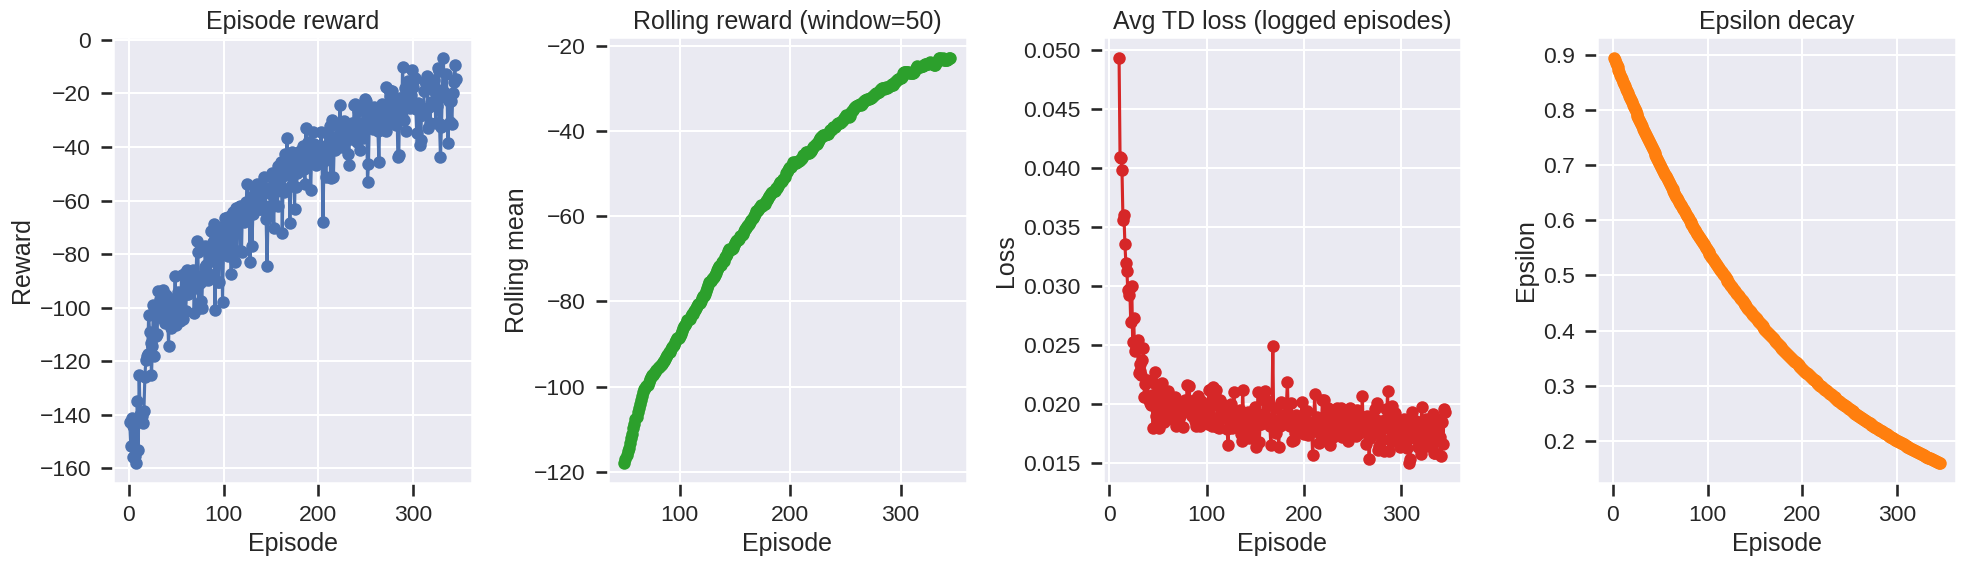

In [97]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
if not training_progress.empty:
    axes[0].plot(training_progress["episode"], training_progress["reward"], marker="o")
    axes[0].set_title("Episode reward")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Reward")

    axes[1].plot(training_progress["episode"], training_progress["rolling_reward"], marker="o", color="#2ca02c")
    axes[1].set_title(f"Rolling reward (window={rolling_window})")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Rolling mean")

    axes[2].plot(training_progress["episode"], training_progress["avg_loss"], marker="o", color="#d62728")
    axes[2].set_title("Avg TD loss (logged episodes)")
    axes[2].set_xlabel("Episode")
    axes[2].set_ylabel("Loss")

    axes[3].plot(training_progress["episode"], training_progress["epsilon"], marker="o", color="#ff7f0e")
    axes[3].set_title("Epsilon decay")
    axes[3].set_xlabel("Episode")
    axes[3].set_ylabel("Epsilon")
else:
    for ax in axes:
        ax.text(0.5, 0.5, "No training data", ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()

plt.tight_layout()

## Policy Evaluation & Metrics

We compare a baseline policy (keep SKUs in their original zone) against the greedy DQN policy ($\epsilon=0$).

In [78]:
baseline_overall = {
    "avg_picking_time": np.average(df["picking_time_seconds"], weights=df["daily_demand"]),
    "avg_travel_distance": np.average(df["travel_distance"], weights=df["daily_demand"]),
    "throughput_orders_per_hour": 3600 / max(1.0, np.average(df["picking_time_seconds"], weights=df["daily_demand"])),
    "layout_efficiency": np.average(df["layout_efficiency_score"], weights=df["daily_demand"]),
    "labor_utilization": min(1.0, np.average(df["zone_load_ratio"], weights=df["daily_demand"]) * 1.05),
    "move_cost": 0.0,
    "pick_time_saved_seconds": 0.0,
}

baseline_congestion = (
    df.groupby("zone")
    .apply(lambda g: (g["daily_demand"].sum() / zone_capacity[g.name]))
 )

def baseline_policy(env: ZoneSlottingEnvDQN) -> int:
    current_zone = env.current_row.get("zone", env.zones[0])
    return env.zone_to_idx.get(current_zone, 0)

class DRQNPolicy:
    def __init__(self, agent: DRQNAgent, context_len: int = 8):
        self.agent = agent
        self.context_len = int(context_len)
        self.state_window: Deque[List[float]] = deque(maxlen=self.context_len)

    def reset(self):
        self.state_window = deque(maxlen=self.context_len)

    def __call__(self, env: ZoneSlottingEnvDQN) -> int:
        state = env._observe(env.current_row)
        self.state_window.append(state)
        action = self.agent.act(list(self.state_window), epsilon=0.0)
        return int(action)

def apply_slotting_policy(frame: pd.DataFrame, policy_fn, capture_paths: bool = False):
    eval_env = ZoneSlottingEnvDQN(frame, zones, zone_capacity, feature_stats)
    state = eval_env.reset()
    records = []
    paths = []
    done = False

    if hasattr(policy_fn, "reset"):
        policy_fn.reset()

    while not done:
        action = policy_fn(eval_env)
        next_state, reward, done, metrics = eval_env.step(action)
        records.append({
            "item_id": metrics.item_id,
            "old_zone": metrics.old_zone,
            "new_zone": metrics.new_zone,
            "baseline_time": metrics.baseline_time,
            "new_time": metrics.new_time,
            "travel_old": travel_distance(metrics.old_zone),
            "travel_new": metrics.travel,
            "demand": metrics.demand,
            "move_cost": metrics.move_cost,
            "layout_score": metrics.layout_score,
            "reward": reward,
            "time_gain_seconds": metrics.time_gain_seconds,
            "value_gain": metrics.value_gain,
            "net_value": metrics.net_value,
        })
        if capture_paths:
            start = staging_point.copy()
            target = np.array(zone_positions[metrics.new_zone], dtype=float)
            path = np.vstack([start, target, start])
            paths.append({"item_id": metrics.item_id, "zone": metrics.new_zone, "path": path})
        state = next_state
    assignments = pd.DataFrame(records)
    if assignments.empty:
        return assignments, paths
    travel_gain = assignments["travel_old"] - assignments["travel_new"]
    assignments["layout_new"] = np.clip(assignments["layout_score"] + travel_gain * 0.05, 0, 1.1)
    assignments["picking_time_saved"] = assignments["baseline_time"] - assignments["new_time"]
    assignments["time_value"] = assignments["time_gain_seconds"] * SLOT_VALUE_PER_SECOND
    return assignments, paths

def summarize_assignments(assignments: pd.DataFrame):
    if assignments.empty:
        return {}, pd.Series(dtype=float)
    avg_pick_new = np.average(assignments["new_time"], weights=assignments["demand"])
    avg_pick_baseline = np.average(assignments["baseline_time"], weights=assignments["demand"])
    avg_travel_new = np.average(assignments["travel_new"], weights=assignments["demand"])
    avg_travel_old = np.average(assignments["travel_old"], weights=assignments["demand"])
    layout_new = np.average(assignments["layout_new"], weights=assignments["demand"])
    time_gain_total = assignments["time_gain_seconds"].sum()
    value_gain_total = assignments.get("time_value", assignments["time_gain_seconds"] * SLOT_VALUE_PER_SECOND).sum()
    net_value_total = assignments["net_value"].sum()
    new_zone_loads = assignments.groupby("new_zone")["demand"].sum()
    capacity_series = pd.Series(zone_capacity)
    congestion = new_zone_loads / capacity_series.reindex(new_zone_loads.index)
    summary = {
        "avg_picking_time": avg_pick_new,
        "avg_travel_distance": avg_travel_new,
        "throughput_orders_per_hour": 3600 / max(1.0, avg_pick_new),
        "layout_efficiency": layout_new,
        "labor_utilization": min(1.0, (congestion.dropna() * 1.05).mean()),
        "move_cost": assignments["move_cost"].sum(),
        "pick_time_saved_seconds": time_gain_total,
        "value_gain": value_gain_total,
        "net_value": net_value_total,
        "baseline_avg_picking_time": avg_pick_baseline,
        "baseline_avg_travel": avg_travel_old,
    }
    return summary, congestion

baseline_assignments, baseline_paths = apply_slotting_policy(slotting_subset, baseline_policy, capture_paths=True)
dqn_policy = DRQNPolicy(agent, context_len=8)
dqn_assignments, dqn_paths = apply_slotting_policy(slotting_subset, dqn_policy, capture_paths=True)

baseline_summary_eval, baseline_congestion_eval = summarize_assignments(baseline_assignments)
dqn_summary_eval, dqn_congestion_eval = summarize_assignments(dqn_assignments)

comparison_df = pd.DataFrame([baseline_summary_eval, dqn_summary_eval], index=["Baseline", "BiLSTM Policy"])
comparison_df["avg_picking_time_delta"] = comparison_df["avg_picking_time"] - comparison_df.loc["Baseline", "avg_picking_time"]
comparison_df["avg_travel_distance_delta"] = comparison_df["avg_travel_distance"] - comparison_df.loc["Baseline", "avg_travel_distance"]
comparison_df["throughput_delta"] = comparison_df["throughput_orders_per_hour"] - comparison_df.loc["Baseline", "throughput_orders_per_hour"]
comparison_df["net_value_delta"] = comparison_df["net_value"] - comparison_df.loc["Baseline", "net_value"]
comparison_df

/tmp/ipykernel_4122516/1478172681.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["daily_demand"].sum() / zone_capacity[g.name]))


,avg_picking_time,avg_travel_distance,throughput_orders_per_hour,layout_efficiency,labor_utilization,move_cost,pick_time_saved_seconds,value_gain,net_value,baseline_avg_picking_time,baseline_avg_travel,avg_picking_time_delta,avg_travel_distance_delta,throughput_delta,net_value_delta
Baseline,145.332754,0.850423,24.770741,0.613463,0.347728,0.00,0.000000,0.000000,0.00000,145.332754,0.850423,0.000000,0.000000,0.000000,0.00000
BiLSTM Policy,144.855694,0.738663,24.852320,0.619051,0.346969,693.32,15269.217996,3359.227959,2185.50333,145.346596,0.850423,-0.477061,-0.111761,0.081579,2185.50333


,metric,baseline,dqn,delta
0,Avg picking time (s),145.332754,144.855694,-0.477061
1,Avg travel distance,0.850423,0.738663,-0.111761
2,Throughput (orders/hr),24.770741,24.852320,0.081579
3,Labor utilisation,0.347728,0.346969,-0.000759
4,Net value,0.000000,2185.503330,2185.503330


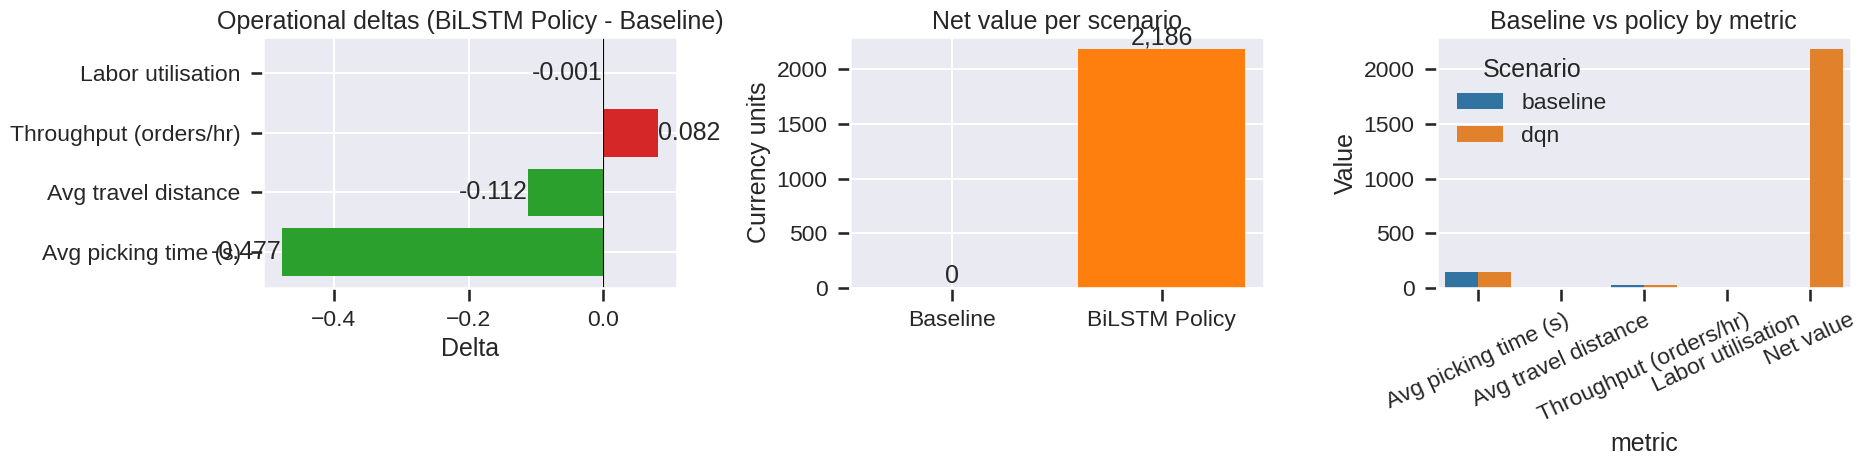

In [79]:
policy_label = "BiLSTM Policy"

impact_metrics = pd.DataFrame(
    {
        "metric": [
            "Avg picking time (s)",
            "Avg travel distance",
            "Throughput (orders/hr)",
            "Labor utilisation",
            "Net value",
        ],
        "baseline": [
            comparison_df.loc["Baseline", "avg_picking_time"],
            comparison_df.loc["Baseline", "avg_travel_distance"],
            comparison_df.loc["Baseline", "throughput_orders_per_hour"],
            comparison_df.loc["Baseline", "labor_utilization"],
            comparison_df.loc["Baseline", "net_value"],
        ],
        "dqn": [
            comparison_df.loc[policy_label, "avg_picking_time"],
            comparison_df.loc[policy_label, "avg_travel_distance"],
            comparison_df.loc[policy_label, "throughput_orders_per_hour"],
            comparison_df.loc[policy_label, "labor_utilization"],
            comparison_df.loc[policy_label, "net_value"],
        ],
    },
)
impact_metrics["delta"] = impact_metrics["dqn"] - impact_metrics["baseline"]

fig, axes = plt.subplots(1, 3, figsize=(19, 5))
operational = impact_metrics.iloc[:4].copy()
axes[0].axvline(0, color="black", linewidth=0.8)
axes[0].barh(
    operational["metric"],
    operational["delta"],
    color=["#2ca02c" if d < 0 else "#d62728" for d in operational["delta"]],
)
axes[0].set_title(f"Operational deltas ({policy_label} - Baseline)")
axes[0].set_xlabel("Delta")
for idx, delta in enumerate(operational["delta"]):
    axes[0].text(delta, idx, f"{delta:.3f}", va="center", ha="left" if delta >= 0 else "right")

value_slice = impact_metrics.iloc[[4]].copy()
axes[1].bar(["Baseline", policy_label], value_slice[["baseline", "dqn"]].values.flatten(), color=["#1f77b4", "#ff7f0e"])
axes[1].set_title("Net value per scenario")
axes[1].set_ylabel("Currency units")
for i, val in enumerate(value_slice[["baseline", "dqn"]].values.flatten()):
    axes[1].text(i, val, f"{val:,.0f}", ha="center", va="bottom")

impact_long = impact_metrics.melt(id_vars="metric", value_vars=["baseline", "dqn"], var_name="scenario", value_name="value")
sns.barplot(data=impact_long, x="metric", y="value", hue="scenario", palette={"baseline": "#1f77b4", "dqn": "#ff7f0e"}, ax=axes[2])
axes[2].set_title("Baseline vs policy by metric")
axes[2].set_ylabel("Value")
axes[2].tick_params(axis="x", rotation=25)
axes[2].legend(title="Scenario")

plt.tight_layout()

impact_metrics

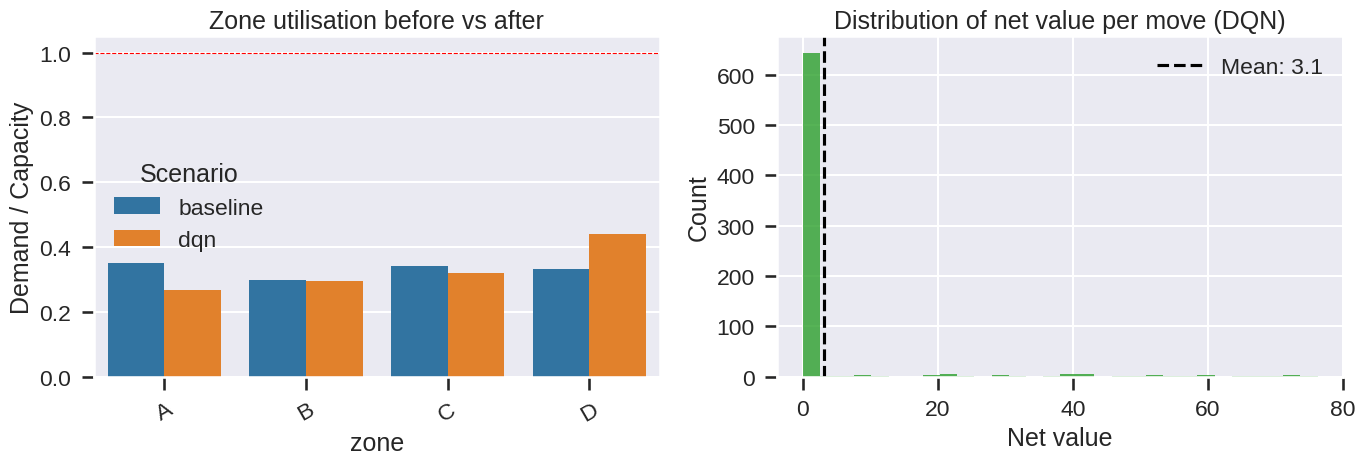

In [72]:
congestion_compare = pd.DataFrame({"baseline": baseline_congestion_eval, "dqn": dqn_congestion_eval}).fillna(0)

if not congestion_compare.empty:
    congestion_long = congestion_compare.reset_index(names="zone").melt(id_vars="zone", value_vars=["baseline", "dqn"], var_name="scenario", value_name="utilisation")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(data=congestion_long, x="zone", y="utilisation", hue="scenario", palette=["#1f77b4", "#ff7f0e"], ax=axes[0])
    axes[0].axhline(1.0, color="red", linestyle="--", linewidth=0.8)
    axes[0].set_title("Zone utilisation before vs after")
    axes[0].set_ylabel("Demand / Capacity")
    axes[0].legend(title="Scenario")
    axes[0].tick_params(axis="x", rotation=30)

    if not dqn_assignments.empty:
        value_hist = dqn_assignments["net_value"].replace([np.inf, -np.inf], np.nan).dropna()
        axes[1].hist(value_hist, bins=30, color="#2ca02c", alpha=0.8)
        axes[1].axvline(value_hist.mean(), color="black", linestyle="--", label=f"Mean: {value_hist.mean():.1f}")
        axes[1].set_title("Distribution of net value per move (DQN)")
        axes[1].set_xlabel("Net value")
        axes[1].set_ylabel("Count")
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, "No DQN moves", ha="center", va="center", transform=axes[1].transAxes)
        axes[1].set_axis_off()

    plt.tight_layout()
else:
    print("No congestion data available.")

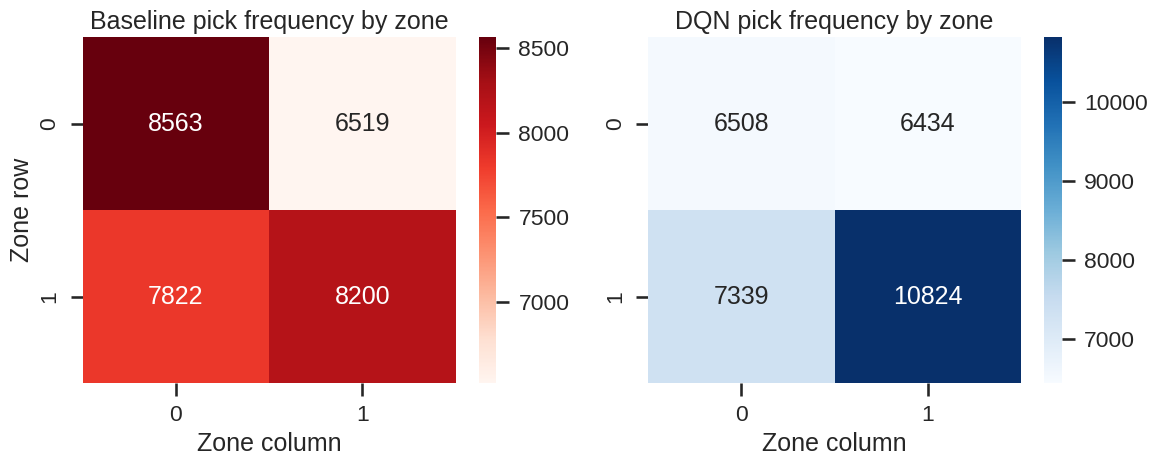

In [73]:
def build_heatmap(values: pd.Series):
    grid = np.zeros((grid_h, grid_w))
    for zone, val in values.items():
        if zone in zone_positions:
            x, y = zone_positions[zone]
            grid[int(x), int(y)] = val
    return grid

baseline_heat = build_heatmap(baseline_assignments.groupby("old_zone")["demand"].sum())
dqn_heat = build_heatmap(dqn_assignments.groupby("new_zone")["demand"].sum())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(baseline_heat, ax=axes[0], cmap="Reds", annot=True, fmt=".0f")
axes[0].set_title("Baseline pick frequency by zone")
axes[0].set_xlabel("Zone column")
axes[0].set_ylabel("Zone row")

sns.heatmap(dqn_heat, ax=axes[1], cmap="Blues", annot=True, fmt=".0f")
axes[1].set_title("DQN pick frequency by zone")
axes[1].set_xlabel("Zone column")
axes[1].set_ylabel("")

plt.tight_layout()

/tmp/ipykernel_4122516/2843311932.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x="scenario", y="picking_time_seconds", palette=["#1f77b4", "#ff7f0e"] )


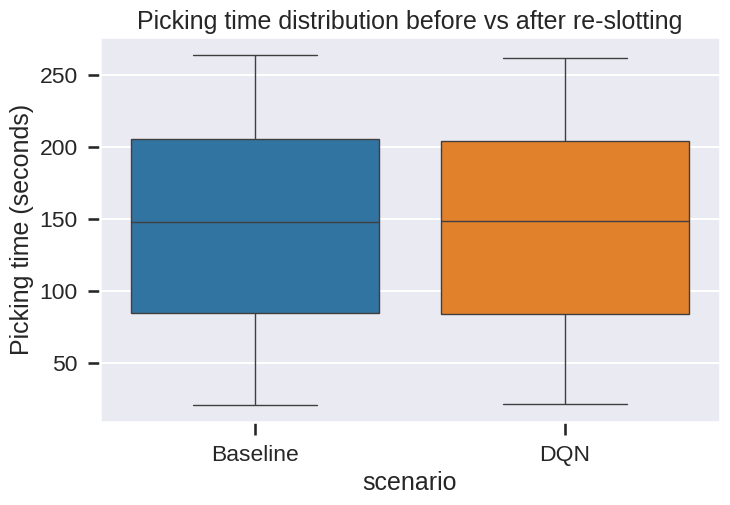

In [74]:
def expand_for_box(assignments: pd.DataFrame, time_col: str, demand_col: str):
    if assignments.empty:
        return np.array([])
    avg_demand = max(assignments[demand_col].mean(), 1)
    weights = np.clip((assignments[demand_col] / avg_demand).round().astype(int), 1, 20)
    return np.repeat(assignments[time_col].values, weights)

baseline_box = expand_for_box(baseline_assignments, "baseline_time", "demand")
dqn_box = expand_for_box(dqn_assignments, "new_time", "demand")

box_data = pd.DataFrame({
    "picking_time_seconds": np.concatenate([baseline_box, dqn_box]),
    "scenario": ["Baseline"] * len(baseline_box) + ["DQN"] * len(dqn_box),
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=box_data, x="scenario", y="picking_time_seconds", palette=["#1f77b4", "#ff7f0e"] )
plt.title("Picking time distribution before vs after re-slotting")
plt.ylabel("Picking time (seconds)")
plt.show()

In [75]:
assignment_compare = baseline_assignments.merge(dqn_assignments, on="item_id", suffixes=("_baseline", "_dqn"))
if not assignment_compare.empty:
    assignment_compare["picking_gain"] = assignment_compare["baseline_time_baseline"] - assignment_compare["new_time_dqn"]
    assignment_compare = assignment_compare.sort_values("net_value_dqn", ascending=False)
    assignment_compare.head(12)[[
        "item_id",
        "old_zone_baseline",
        "new_zone_dqn",
        "baseline_time_baseline",
        "new_time_dqn",
        "picking_gain",
        "demand_dqn",
        "move_cost_dqn",
        "net_value_dqn",
        "time_gain_seconds_dqn",
    ]]
else:
    print("No assignment comparison available.")